AUC, ou Área sob a Curva (Area Under the Curve), é uma métrica utilizada para avaliar a performance de modelos de classificação, especialmente em problemas binários. Ela representa a área sob a curva ROC (Receiver Operating Characteristic), que plota a taxa de verdadeiros positivos (sensibilidade) contra a taxa de falsos positivos (1 - especificidade) em diferentes limiares de classificação.
Principais Pontos sobre AUC:

    Intervalo: AUC varia de 0 a 1. Um AUC de 0,5 indica um modelo que não tem poder preditivo (equivalente a um palpite aleatório), enquanto um AUC de 1,0 indica um modelo perfeito.
    
    Interpretação: Quanto maior o AUC, melhor o modelo é em distinguir entre as classes positivas e negativas.
    
    Robustez: AUC é uma métrica robusta, pois considera todos os possíveis limiares de classificação, tornando-a útil em situações com classes desbalanceadas.


In [9]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
# from scipy import interp
interp = np.interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [10]:
# Base de Dados
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [11]:
# Binarizar
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [12]:
# Adicionando Ruído
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 150 * n_features)]

In [13]:
# Embaralhar e dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.45,
                                                    random_state=0)

In [14]:
# Estratégia OvR (Predizer cada uma das classe contra as outras)
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [15]:
# Computar ROC e sua area (ROCAUC) para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [16]:
# Computar micro-média da ROC e ROCAUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

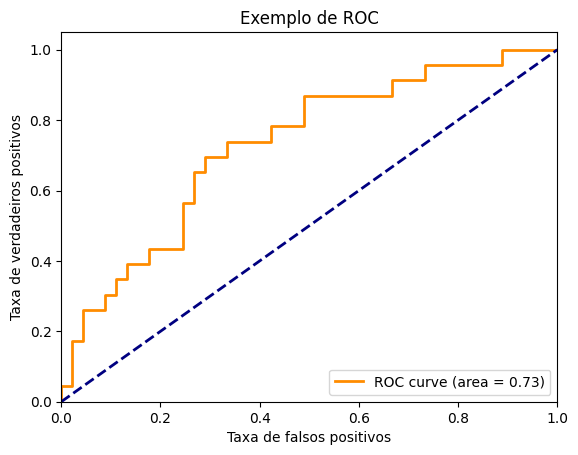

In [17]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Exemplo de ROC')
plt.legend(loc="lower right")
plt.show()
# ROC = Receiver operating characteristic 

## Plotar ROC curvas para o problema multiclasse

Computar macro-média da ROC curva e a AUC

In [21]:
# Primeiro, agregue todas as taxas de falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [22]:
# Em seguida, interpole todas as curvas ROC nesses pontos.
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [23]:
# Calcular média e computar AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

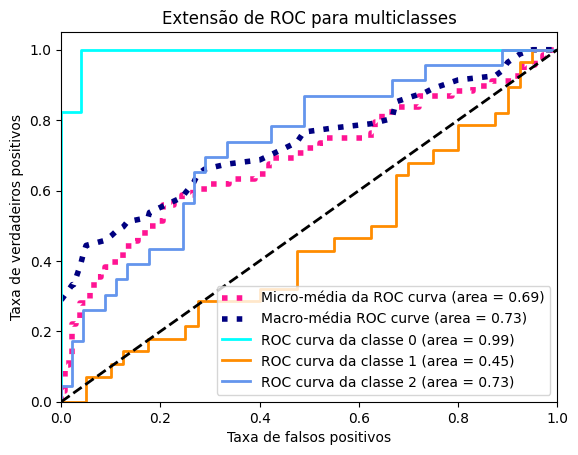

In [24]:
# Plotar todas as curvas de ROC
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-média da ROC curva (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-média ROC curve (area = {roc_auc["macro"]:0.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curva da classe {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Extensão de ROC para multiclasses')
plt.legend(loc="lower right")
plt.show()